In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_kanamori, h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from h5 import HDFArchive
from triqs.atom_diag import *
import numpy as np
import sympy as sp
from itertools import product
import matplotlib.pylab as plt

In [2]:
# Definition of a 3-orbital atom
spin_names = ('up','dn')
orb_names = [0,1]
beta = 1000
target_occ = 2
U = 20
t = 1.0
mu = 10.0

uijkl = np.zeros((2,2,2,2))
uijkl[0,0,0,0] = U
uijkl[1,1,1,1] = U

tij = np.zeros((2,2))
tij[0,1] = t
tij[1,0] = t

# Set of fundamental operators
fops = [(sn,on) for sn, on in product(spin_names,orb_names)]

# Numbers of particles with spin up/down
N_up = n('up',0) + n('up',1)
N_dn = n('dn',0) + n('dn',1)
N = N_up + N_dn

# Add chemical potential
H = 0 * (N_up + N_dn)

# Add Coulomb
H += h_int_slater(spin_names, orb_names, uijkl, off_diag=True, complex=True)

# Add single partcle terms
for s, o1, o2 in product(spin_names, orb_names, orb_names):
    H += 0.5*(        tij[int(o1),int(o2)]  * c_dag(s,o1) * c(s,o2) + 
              np.conj(tij[int(o1),int(o2)]) * c_dag(s,o2) * c(s,o1))

In [3]:
step = 0.5
while True:

    H += mu * N
    ad = AtomDiagComplex(H, fops, n_min=target_occ-1, n_max=target_occ+1)

    beta = 1e5
    dm = atomic_density_matrix(ad, beta)
    filling = trace_rho_op(dm, N, ad)

    if abs(filling.real-target_occ) < 1.0e-4:
        break
    elif filling.real < target_occ:
        H += -mu * N
        mu+=-step
    elif filling.real > target_occ:
        H += -mu * N
        mu+=step    
    
print("mu:", mu, "filling:", filling)

mu: -1.0 filling: (1.9999999999999973+0j)


In [4]:
?atomic_g_w

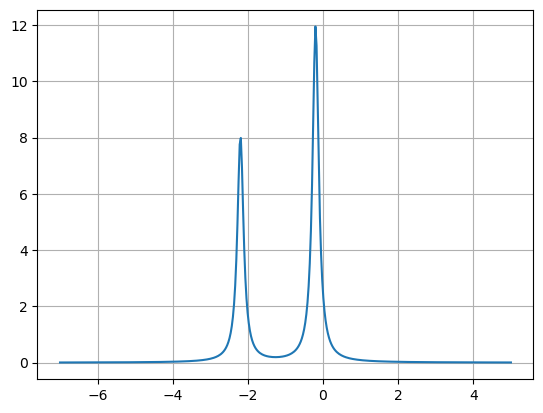

In [5]:
gf_struct = [('dn', len(orb_names)),
             ('up', len(orb_names))]

G_w = atomic_g_w(ad, beta, gf_struct, (-7, 5), 400, 0.1)

f = np.array(list(G_w['up'].mesh.values()))
plt.figure(1)
plt.clf()
plt.grid(True)
plt.plot(f, -np.imag(np.trace(G_w['up'].data[:,:,:], axis1=1, axis2=2))+
            -np.imag(np.trace(G_w['dn'].data[:,:,:], axis1=1, axis2=2)) ) 

In [6]:
S2 = S2_op(spin_names, orb_names, off_diag=True)
S2 = make_operator_real(S2)
Sz = S_op('z', spin_names, orb_names, off_diag=True)
Sz = make_operator_real(Sz)


S2_states = quantum_number_eigenvalues(S2, ad)
Sz_states = quantum_number_eigenvalues(Sz, ad)

n_eig = 0
n_orb = len(orb_names)
n_spin = len(spin_names)
for sub in range(0,ad.n_subspaces):
    
    subspace_fock_state=[]
    for fs in ad.fock_states[sub]:
        state =int(bin(int(fs))[2:])                
        state_leng=n_orb*n_spin
        fmt='{0:0'+str(state_leng)+'d}'
        state_bin="|"+fmt.format(state)+">"
        state_bin_sym=sp.symbols(state_bin)
        subspace_fock_state.append(state_bin_sym)

    # convert to eigenstate 
    kp = sp.kronecker_product
    u_mat=sp.Matrix(np.round(ad.unitary_matrices[sub],3).conj().T)
    st_mat=sp.Matrix(subspace_fock_state)
    eig_state=np.matrix(u_mat*st_mat)
    
    for ind in range(0,ad.get_subspace_dim(sub)):

        # Get desired states in eigenvector basis
        state_eig = np.zeros((int(ad.full_hilbert_space_dim)))
        state_eig[n_eig]=1.0        

        # Construct density matrix
        den_mat=np.zeros((n_spin*n_orb,n_spin*n_orb))
        for s1 in range(0,n_spin):
            for s2 in range(0,n_spin):
                for ii in range(0,n_orb):
                    for jj in range(0,n_orb):

                        den_op = c_dag(spin_names[s1],orb_names[ii]) * c(spin_names[s2],orb_names[jj])

                        xx = ii + s1*n_orb
                        yy = jj + s2*n_orb

                        den_mat[xx,yy]=np.real(np.dot(state_eig, act(den_op, state_eig, ad)))
                        
        if(np.allclose(np.trace(den_mat), target_occ)):
            print("state #",n_eig )
            print("energy =", np.round(ad.energies[sub][ind], decimals=2), "  S2 =", np.round(S2_states[sub][ind], decimals=2), "  Sz =", np.round(Sz_states[sub][ind], decimals=2))
            print("state =", eig_state[ind])
            print(np.round(den_mat, decimals=2))
            print("")
        
        n_eig += 1

state # 0
energy = 0.0   S2 = 0.0   Sz = 0.0
state = [[-0.07*|0101> + 0.704*|0110> + 0.704*|1001> - 0.07*|1010>]]
[[ 0.5 -0.1  0.   0. ]
 [-0.1  0.5  0.   0. ]
 [ 0.   0.   0.5 -0.1]
 [ 0.   0.  -0.1  0.5]]

state # 1
energy = 0.2   S2 = 2.0   Sz = -0.0
state = [[0.707*|0110> - 0.707*|1001>]]
[[ 0.5 -0.   0.   0. ]
 [-0.   0.5  0.   0. ]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.5]]

state # 2
energy = 20.2   S2 = 0.0   Sz = -0.0
state = [[-0.707*|0101> + 0.707*|1010>]]
[[ 0.5  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.   0.5 -0. ]
 [ 0.   0.  -0.   0.5]]

state # 3
energy = 20.4   S2 = 0.0   Sz = 0.0
state = [[0.704*|0101> + 0.07*|0110> + 0.07*|1001> + 0.704*|1010>]]
[[0.5 0.1 0.  0. ]
 [0.1 0.5 0.  0. ]
 [0.  0.  0.5 0.1]
 [0.  0.  0.1 0.5]]

state # 6
energy = 0.2   S2 = 2.0   Sz = 1.0
state = [[1.0*|0011>]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

state # 9
energy = 0.2   S2 = 2.0   Sz = -1.0
state = [[1.0*|1100>]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1